Files already downloaded and verified
Files already downloaded and verified
Training model with regular dropout...
Epoch 1/20:
Training Loss: 1.6661
Test Accuracy: 48.38%
--------------------------------------------------
Epoch 2/20:
Training Loss: 1.3652
Test Accuracy: 57.07%
--------------------------------------------------
Epoch 3/20:
Training Loss: 1.2468
Test Accuracy: 61.60%
--------------------------------------------------
Epoch 4/20:
Training Loss: 1.1587
Test Accuracy: 63.93%
--------------------------------------------------
Epoch 5/20:
Training Loss: 1.1084
Test Accuracy: 66.15%
--------------------------------------------------
Epoch 6/20:
Training Loss: 1.0525
Test Accuracy: 66.88%
--------------------------------------------------
Epoch 7/20:
Training Loss: 1.0139
Test Accuracy: 70.39%
--------------------------------------------------
Epoch 8/20:
Training Loss: 0.9806
Test Accuracy: 68.62%
--------------------------------------------------
Epoch 9/20:
Training Loss: 0.

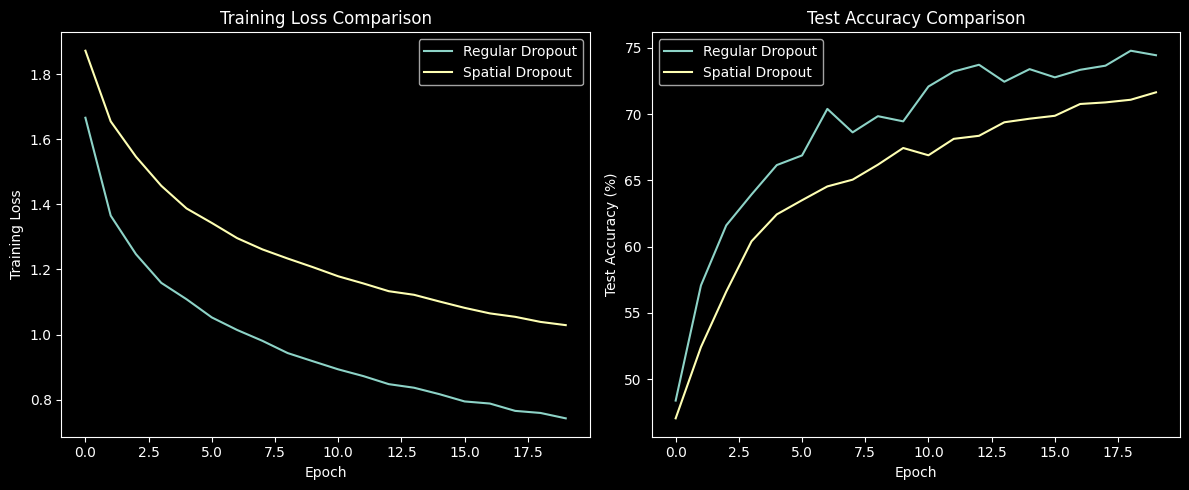

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define the CNN architecture with regular dropout
class CNNWithRegularDropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNNWithRegularDropout, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate)  # Regular dropout
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate)  # Regular dropout
        )
        
        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.view(-1, 128 * 8 * 8)
        x = self.fc(x)
        return x

# Define the CNN architecture with spatial dropout
class CNNWithSpatialDropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNNWithSpatialDropout, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # Spatial dropout: drop entire feature maps
            nn.Dropout2d(dropout_rate)
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Spatial dropout: drop entire feature maps
            nn.Dropout2d(dropout_rate)
        )
        
        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Regular dropout for fully connected layers
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.view(-1, 128 * 8 * 8)
        x = self.fc(x)
        return x

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # Evaluation phase
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        
        print(f'Epoch {epoch + 1}/{num_epochs}:')
        print(f'Training Loss: {epoch_loss:.4f}')
        print(f'Test Accuracy: {accuracy:.2f}%')
        print('-' * 50)
    
    return train_losses, test_accuracies

# Main execution
def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load and preprocess CIFAR-10 dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, transform=transform, download=True)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Training parameters
    num_epochs = 20
    learning_rate = 0.001
    dropout_rate = 0.5
    
    # Initialize models
    regular_dropout_model = CNNWithRegularDropout(dropout_rate).to(device)
    spatial_dropout_model = CNNWithSpatialDropout(dropout_rate).to(device)
    
    # Loss function and optimizers
    criterion = nn.CrossEntropyLoss()
    regular_optimizer = optim.Adam(regular_dropout_model.parameters(), lr=learning_rate)
    spatial_optimizer = optim.Adam(spatial_dropout_model.parameters(), lr=learning_rate)
    
    # Train both models
    print("Training model with regular dropout...")
    regular_losses, regular_accuracies = train_model(
        regular_dropout_model, train_loader, test_loader,
        criterion, regular_optimizer, num_epochs, device
    )
    
    print("\nTraining model with spatial dropout...")
    spatial_losses, spatial_accuracies = train_model(
        spatial_dropout_model, train_loader, test_loader,
        criterion, spatial_optimizer, num_epochs, device
    )
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    # Plot training losses
    plt.subplot(1, 2, 1)
    plt.plot(regular_losses, label='Regular Dropout')
    plt.plot(spatial_losses, label='Spatial Dropout')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    
    # Plot test accuracies
    plt.subplot(1, 2, 2)
    plt.plot(regular_accuracies, label='Regular Dropout')
    plt.plot(spatial_accuracies, label='Spatial Dropout')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy Comparison')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()